In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [2]:
df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [3]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [4]:
close_df = df[['Date', 'Close']]

In [5]:
def window(df, column_name, k):
    df_copy = df.copy()  
    for i in range(1, k + 1):
        new_column_name = f"{column_name}-{i}"
        df_copy[new_column_name] = df_copy[column_name].shift(i)
    column_names = list(df_copy.columns)
    return df_copy.iloc[:, ::-1].drop(range(k))

def dataset(df, window_size): 
    close_df = window(df, 'Close', window_size)
    close_df_copy = close_df.copy()
    close_df_copy = close_df_copy.drop('Date', axis = 1)
    
    X = close_df_copy.drop(columns = 'Close')
    y = close_df_copy['Close'] 
    
    scaler_X = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.to_numpy().reshape(-1, 1))
    
    train_size = int(len(X) * 0.8)
    test_size = len(X) - train_size

    X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
    y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]
    return X_train, X_test, y_train, y_test, scaler_y

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape

# Load model

In [6]:
model_load_7 = load_model(f'tesla_model_lstm/model_tesla_window_7_0.010645732663668563.h5')
model_load_30 = load_model(f'tesla_model_lstm/model_tesla_window_30_0.010407419281699032.h5') 
model_load_60 = load_model(f'tesla_model_lstm/model_tesla_window_60_0.009866144058738683.h5')

models = [model_load_7, model_load_30, model_load_60]
windows = [7,30,60]

In [7]:
def metrics(models, windows):
    
    mae_lst = []
    RMSE_lst = []
    MAPE_lst = []
    r2_lst = []

    y_PRED_all = []
    for model, window_size in zip(models, windows):
        X_train, X_test, y_train, y_test, scaler_y = dataset(close_df, window_size)
        test_predictions = model.predict(X_test).flatten()
        test_predictions = np.expand_dims(test_predictions, axis=1)
        test_predictions = scaler_y.inverse_transform(test_predictions)
        
        #test_y = np.expand_dims(y_test, axis=1)
        y_test1 = scaler_y.inverse_transform(y_test)
            
        y_TEST = y_test1[-256:]
        y_PRED = test_predictions[-256:]
        
        mae = mean_absolute_error(y_TEST, y_PRED)
        RMSE = rmse(y_TEST, y_PRED)
        MAPE = calculate_mape(y_TEST, y_PRED)
        r2 = r2_score(y_TEST, y_PRED)
        
        mae_lst.append(mae)
        RMSE_lst.append(RMSE)
        MAPE_lst.append(MAPE)
        r2_lst.append(r2)
        y_PRED_all.append(y_PRED)

    return mae_lst, RMSE_lst, MAPE_lst, r2_lst, y_PRED_all, y_TEST

In [8]:
mae_lst, RMSE_lst, MAPE_lst, r2_lst, y_PRED, y_TEST = metrics(models,windows)

8/8 [==============================] - 1s 6ms/step


In [27]:
metrics_df = pd.DataFrame({
    'Window Size': windows,
    'MAE': [mae_lst[0], mae_lst[1], mae_lst[2]],
    'RMSE': [RMSE_lst[0], RMSE_lst[1], RMSE_lst[2]],
    'MAPE': [MAPE_lst[0], MAPE_lst[1], MAPE_lst[2]]
})
metrics_df

,Window Size,MAE,RMSE,MAPE
0,7,4.932563,6.732781,[2.2656906354282156]
1,30,4.916919,6.702849,[2.258706175997863]
2,60,4.938694,6.648864,[2.2669942971925416]


In [9]:
y_PRED_all = []
for i in y_PRED:
    lst = []
    for j in i:
        lst.append(j[0])
    y_PRED_all.append(lst)

In [10]:
y_TEST_ = [i[0] for i in y_TEST]

In [13]:
len(y_PRED_all[0])

256

In [20]:
test_results = pd.DataFrame(data={'Window size 7':y_PRED_all[0], 'Window size 30':y_PRED_all[1], 'Window size 60':y_PRED_all[2], 'Actual':y_TEST_, 'Date': close_df['Date'].iloc[-256:]})

In [21]:
test_results

,Window size 7,Window size 30,Window size 60,Actual,Date
1083,163.624969,164.939301,164.867920,165.080002,2023-04-21
1084,165.118317,164.192825,165.562851,162.550003,2023-04-24
1085,160.350433,160.927551,162.706879,160.669998,2023-04-25
1086,159.699661,157.730164,159.521255,153.750000,2023-04-26
1087,152.244247,153.048935,154.805191,160.190002,2023-04-27
...,...,...,...,...,...
1334,144.900040,146.050476,147.216202,142.050003,2024-04-22
1335,141.801483,142.647552,143.878555,144.679993,2024-04-23
1336,143.329376,144.076462,144.918106,162.130005,2024-04-24
1337,159.304214,157.860443,157.540176,170.179993,2024-04-25


In [22]:
test_results = test_results.set_index('Date')

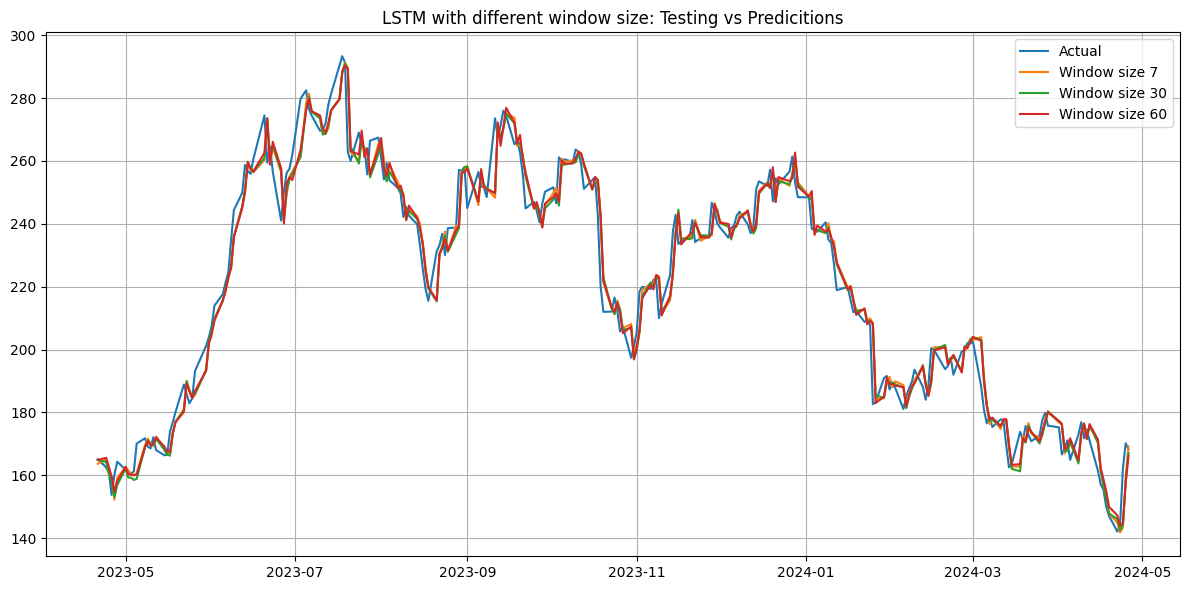

In [26]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actual'], label = 'Actual')
plt.plot(test_results['Window size 7'], label = 'Window size 7')
plt.plot(test_results['Window size 30'], label = 'Window size 30')
plt.plot(test_results['Window size 60'], label = 'Window size 60')
plt.title('LSTM with different window size: Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()